# Ultrasound Diffraction Lab


In [1]:
import numpy as np
import scipy.stats as stats

%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15, 7)
plt = matplotlib.pyplot

import scipy.constants as constants
import scipy.interpolate as interpolate

import ipywidgets as widgets

import sympy
sympy.init_printing()

In [2]:
# Helper functions
def csv_to_array(filename):
    """
    Read data from a comma-separated-value file
    into a 2D NumPy array.
    """
    f = open(filename, 'rb')
    return np.loadtxt(f, delimiter=',')

def group_by_x(data):
    """
    Group a 2D array by x-value, if we have multiple y values.
    Returns a dictionary of (x value) -> [y value list] pairs.
    """
    grouped = {}
    for x, y in data:
        if x not in grouped:
            grouped[x] = []
        grouped[x].append(y)
    return grouped

def quadtrature(*values):
    """
    Add all of the arguments in quadtrature, element-wise.
    """
    np.power(values, 2)
    return np.sqrt(np.sum(np.power(values, 2),axis=0))

def amplitude_to_intensity(data):
    """
    Convert a 2d array of angle-amplitude-error data into
    angle-intensity-error data.
    """
    intense_data = data.copy()
    # Square the value
    intense_data[:,1] **= 2
    # Handle the error
    intense_data[:,2] = 2 * data[:,2]/data[:,1] * intense_data[:,1]

    return intense_data

def clip_array(data, to_bounds_of):
    """
    Clips the data in the 2D array, "data", where the x-values
    fall outside the range of the x-values of "to_bounds_of".
    Assumes "to_bounds_of" is ordered smallest-to-largest.
    """
    # Return elements of data where...
    return data[
        # The elements meet both of the folling conditions...
        np.logical_and(
            # The x-values are greater than the smallest x-value in to_bounds_of
            to_bounds_of[0,0] < data[:,0],
            # The x-values are less than the biggest x-value in to_bounds_of
            data[:,0] < to_bounds_of[-1,0]
        )
    ]

In [3]:
# Units
m = 1.0
cm = 1e-2
mm = 1e-3
Hz = 1.0
volts = 1.0
degree = constants.pi/180.0
degrees_c = 1.0

## Recorded Data

In [4]:
# Distance to between the middle of turntable to the receiver
distance = 223.5*cm
distance_d = 1*cm

frequency = 4020*Hz

distance_2 = 11*cm
distance_2_d = 0.5*cm

perpendicular = -10 * degree
perpendicular_d = 1 * degree

lab_temperature = 24.2*degrees_c
lab_temperature_d = 0.2*degrees_c

slat_width = 2.0*cm
slat_width_d = 1.0*mm

slit_width = 1.1*cm
slit_width_d = 1.0*mm

angle_rads_voltage_data = np.array([
    [3.09867*volts, -30*degree],
    [2.70056*volts,   0*degree],
    [2.29335*volts,  30*degree],
])

# Import
data_noise_raw  = csv_to_array(r'./noise.csv')
data_1_slit_raw = csv_to_array(r'./1slit.csv')
data_2_slit_raw = csv_to_array(r'./2slits.csv')
data_4_slit_raw = csv_to_array(r'./4slits.csv')
data_6_slit_raw = csv_to_array(r'./6slits.csv')

# The imported data is placed in a matrix like:
# [[xvalue, yvalue],
#  [xvalue, yvalue],
#  ...
#  [xvalue, yvalue]]
#
# We access the x-values, and y values like so:
# Xs = data[:,0]
# Ys = data[:,1]
# We will also add another column, yerr:
# Y_err = data[:,2]

In [5]:

# The potentiometer in the turn-table is linear,
# so we can just come up with a constant to
# multiply readings with to convert them to rads.

# slope = rise/run
slope = ((angle_rads_voltage_data[-1,1] - angle_rads_voltage_data[0,1] ) /
         (angle_rads_voltage_data[-1,0] - angle_rads_voltage_data[0,0] ))

# offset = angle-slope*reading
offset = angle_rads_voltage_data[-1,1] - slope*angle_rads_voltage_data[-1,0]

print('Relationship between turntable voltage and angle:')
print('angle={:.4f}*reading{:+.4f}'.format(slope,offset))

def voltage_to_radians(reading_Volts):
    """
    Convert a voltage reading from the turn-table
    into an angle in radians
    """
    return slope*reading_Volts+offset


Relationship between turntable voltage and angle:
angle=-1.3003*reading+3.5058


## Interpolation of Noise Floor
##### To remove sources of systematic error
We want to subtract the noise floor (0-slit readings) from all
the other readings to remove systematic error. To do this, we
need to interpolate the noise floor between points, since the
x-values in the noise floor readings won't necessarily match
the x-values of the readings.

We generate an interative plot to manually adjust the parameters
of the spline to fit the data &mdash; these are then propagated through
the notebook.

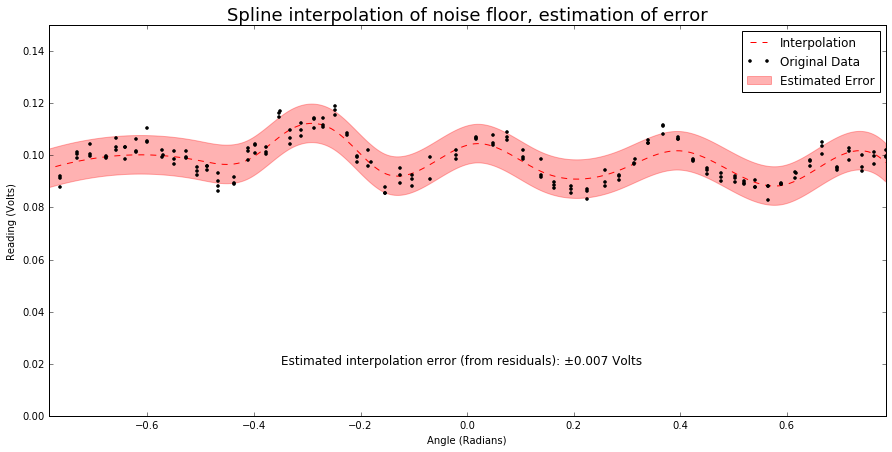

In [32]:
data_noise = data_noise_raw.copy()
# Convert turntable potentiometer readings to radians
data_noise[:,0] = voltage_to_radians(data_noise_raw[:,0])
# We also had an offset on the angle of our system,
# i.e. 0deg was not the max amplitude. Subtract this difference:
data_noise[:,0] = data_noise[:,0] - perpendicular

# Manually adjust smoothing factor to desired result
@widgets.interact(
    smoothing_factor=widgets.IntSlider(min=7, max=100, step=1, value=15, description="Smoothing Factor ($\\times 10^{-4}$)"),
)
def man_adjust(smoothing_factor):
    global noise_interp, noise_interp_err
    # Do the interpolation
    noise_interp = interpolate.UnivariateSpline(
        # X-values
        data_noise[:,0],
        # Y-values
        data_noise[:,1]
    )
    noise_interp.set_smoothing_factor(smoothing_factor*1e-4)

    # Also interpolate the error\
    noise_interp_err = interpolate.interp1d(
        # x-values
        data_noise[:,0],
        # y-value errors
        np.ones(len(data_noise[:,0]))*noise_interp.get_residual()*2,
        kind='linear'
    )

    # And now show the continuous interpolation
    x_values = np.linspace(data_noise[0,0], data_noise[-1,0], 500)
    plt.plot(x_values, noise_interp(x_values), 'r--', label='Interpolation');
    # And here's a plot of the errors, also continuous
    plt.fill_between(
        x_values,
        noise_interp(x_values)-noise_interp_err(x_values),
        noise_interp(x_values)+noise_interp_err(x_values),
        color='red',
        alpha=0.3,
        label='Estimated Error'
    )
    # And now overlay the original data
    plt.plot(data_noise[:,0], data_noise[:,1], 'k.', label='Original Data')
    plt.title('Spline interpolation of noise floor, estimation of error', fontsize=18)
    plt.ylabel('Reading (Volts)')
    plt.xlabel('Angle (Radians)')
    plt.ylim(0, 0.15);
    plt.xlim(-constants.pi/4, constants.pi/4);
    plt.legend()
    plt.text(-0.35, 0.02,
             'Estimated interpolation error (from residuals): ±{:.3f} Volts'.format(
            noise_interp.get_residual()*2
        ), fontsize=12)
    plt.show();

## Process data
Now we need to do the following for each data set:
- Convert the reading from the turntable potentiometer into radians
- Subtract the perpendicular angle, so that the readings will be centered at 0
- Calculate the mean, and error on the mean of the readings
- Clip the data set to the bounds of the noise floor
- Remove the noise from the data set
- Convert amplitude to intensity
- Adjust the error of each data point accodingly

In [20]:
def process_data(data_raw):
    
    len_v, len_h = np.shape(data_raw)
    data = np.ndarray((len_v, len_h+1))
    data[:,[0,1]]=  data_raw.copy()
    
    # Convert the voltage readings from the turn-table
    # potentiometer into radians
    data[:,0] = voltage_to_radians(data[:,0])
    
    # We also had an offset on the angle of our system,
    # i.e. 0deg was not the max amplitude. Subtract this difference:
    data[:,0] = data[:,0] - perpendicular
    
    # Clip the data to the fartest extents of the noise floor
    data = clip_array(data, data_noise)
    
    # Subtract the interpolated noise floor from the readings
    data[:,1] = data[:,1]-noise_interp(data[:,0])
    
    # And adjust the error accordingly
    data[:,2] = noise_interp_err(data[:,0])
    # Convert from amplitude to intensity and handle error propagation
    data = amplitude_to_intensity(data)
    
    return data


data_1_slit = process_data(data_1_slit_raw)
data_2_slit = process_data(data_2_slit_raw)
data_4_slit = process_data(data_4_slit_raw)
data_6_slit = process_data(data_6_slit_raw)

## Plot the readings

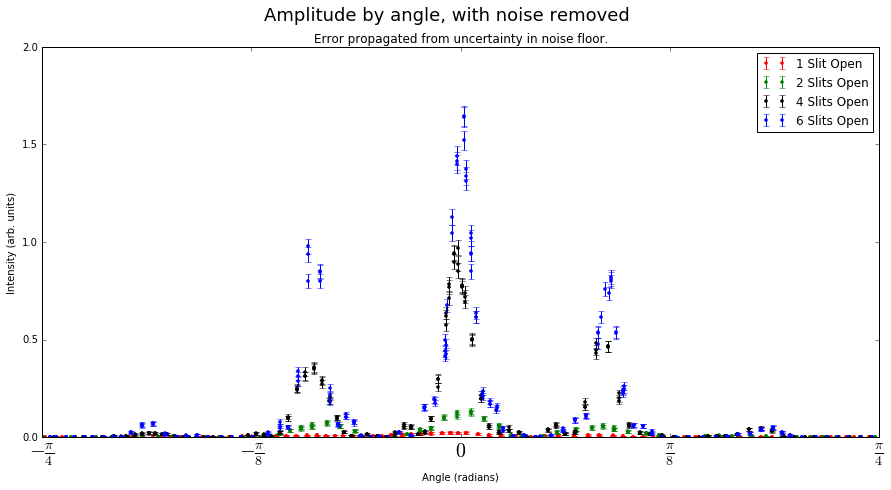

In [21]:
# Set up an interactive plot, where we can select which datasets to show
ticks = [-sympy.pi/4, -sympy.pi/8, 0, sympy.pi/8, sympy.pi/4]
print(ticks)

@widgets.interact(one_slit=True,two_slit=True,four_slit=True,six_slit=True)
def widget(one_slit,two_slit,four_slit,six_slit):
    
    fig = plt.figure()
    ax  = fig.add_subplot(111)
    y_label = ['$'+sympy.latex(t)+'$' for t in ticks]
    ax.set_xticks([sympy.N(t) for t in ticks])
    ax.set_xticklabels(y_label, fontsize=20)

    one_slit  and  ax.errorbar(data_1_slit[:,0], data_1_slit[:,1], data_1_slit[:,2], fmt='r.', label='1 Slit Open')
    two_slit   and ax.errorbar(data_2_slit[:,0], data_2_slit[:,1], data_2_slit[:,2], fmt='g.', label='2 Slits Open')
    four_slit  and ax.errorbar(data_4_slit[:,0], data_4_slit[:,1], data_4_slit[:,2], fmt='k.', label='4 Slits Open')
    six_slit   and ax.errorbar(data_6_slit[:,0], data_6_slit[:,1], data_6_slit[:,2], fmt='b.', label='6 Slits Open')

    fig.suptitle('Amplitude by angle, with noise removed', fontsize=18)
    ax.set_title('Error propagated from uncertainty in noise floor.', fontsize=12)
    ax.set_xlabel('Angle (radians)')
    ax.set_ylabel('Intensity (arb. units)')
    ax.set_ylim(0)
    ax.set_xlim(float(ticks[0]), float(ticks[-1]))
    (one_slit or two_slit or four_slit or six_slit) and ax.legend();


In [22]:

ticks = [-sympy.pi/4, -sympy.pi/8, 0, sympy.pi/8, sympy.pi/4]
print(ticks)
# ticks = map(lambda nd: sympy.pi*sympy.Rational(*nd), [(-1,4), (-1,8), (0,1), (1/8), (1/4)])
print(list(ticks))
map(sympy.N, ticks)

[-pi/4, -pi/8, 0, pi/8, pi/4]
[-pi/4, -pi/8, 0, pi/8, pi/4]
